<a href="https://colab.research.google.com/github/SimplyDifficult/ML-for-Wireless/blob/main/1_SE_vs_Power%20(EPA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bayesian Optimization (BO)**

In [ ]:
#### We are using octave to use the code of matlab.
#### Its main purpose is to generate the samples for the BO loop

!apt install octave

In [ ]:
#### These are the matlab/octave files which will be used for generating the samples

!wget https://www.dropbox.com/s/seo8s2j969cbewp/function_SE.m
!wget https://www.dropbox.com/s/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m
!wget https://www.dropbox.com/s/k3thopidesa905h/main.m

In [ ]:
#### Importing necessary packages

from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
#from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot
from scipy.optimize import minimize
import numpy as np
from scipy.io import loadmat, savemat
import random

In [ ]:
#### Objective/Performace function(We are using Spectral Efficacy here)
#### We have four cells and 100 users in each cell.
#### I am collecting samples 16 times, where in each time I collect samples of 5 users in each cell.
#### Its like how the paper had suggested to do.

def objective(transmit_power):
  #We have transmit power in dB however octave code accepts it in mW. 
  tr_in_mW = pow(10,(transmit_power*1.0/10))
  savemat("transmit.mat", {"transmit":(tr_in_mW*1.0)})
  #Here we run the octave code
  !octave -W main.m
  #And save the result in SE matrix
  SE = loadmat('SE.mat')
  storer = 0
  for i in range(16):
    randomlist1 = random.sample(range(0, 10), 5)
    randomlist2 = random.sample(range(0, 10), 5)
    randomlist3 = random.sample(range(0, 10), 5)
    randomlist4 = random.sample(range(0, 10), 5)
    SE_matrix = SE["SE"]
    r1 = SE_matrix[randomlist1,0]
    r2 = SE_matrix[randomlist2,1]
    r3 = SE_matrix[randomlist3,2]
    r4 = SE_matrix[randomlist4,3]
    storer = storer + np.sum(r1) + np.sum(r2) + np.sum(r3) + np.sum(r4)
  return (storer/16.0)

In [ ]:
#### Surrogate or approximation for the objective function

def surrogate(model, X):
	#catch any warning generated when making a prediction
	with catch_warnings():
		#ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)

In [ ]:
#### Probability of Improvement Acquisition Function(PI)

def PIacquisition(X, Xsamples, model):
	#calculate the best surrogate score found so far
	yhat, _ = surrogate(model, X)
	best = max(yhat)
	#calculate mean and stdev via surrogate function
	mu, std = surrogate(model, Xsamples)
	mu = mu[:, 0]
	#calculate the probability of improvement
	probs = norm.cdf((mu - best) / (std+1E-30))
	return probs

In [ ]:
#### Expected Improvement Acquisition Function(EI)

def EIacquisition(X, Xsamples, model, y):
  yhat, _ = surrogate(model, X)
  best = max(yhat)
  mu, std = surrogate(model, Xsamples)
  mu = mu[:, 0]
  sigma = 0
  probs = (mu - best - sigma) * norm.cdf((mu - best - sigma)/(std+1e-10)) + std * norm.pdf((mu - best - sigma)/(std+1e-10))
  return probs

In [ ]:
#### Knowledge Gradient Acquisition Function(KG)

def KGacquisition(X, Xsamples, model, y):

  #Find the best achieved performace
  u_n, _ = surrogate(model, Xsamples)
  u_star_n = max(u_n)
 
  #Maxima KG and its optimal X
  KG_max = -9999999999999999
  KG_x = -999999999999999

  for i in Xsamples:

    #Take one sample point 
    sample_point = i

    #collect its mean and variance
    temp1 = surrogate(model, np.array([i]))
    mu_of_test_point = temp1[0][0][0]
    std_of_test_point =  temp1[1][0]

    #Store the samples of KG in this
    temp_KG = 0

    #Take 50 samples of its gaussian posterior
    for j in range(50):

      #New observation collected
      y_n_plus_1 = mu_of_test_point + (std_of_test_point) * normal(loc=0, scale=1)

      #New model calculated
      model.fit(vstack((X, [i])), vstack((y, [[y_n_plus_1]])))

      #The next best performance achieved
      u_n_plus_1, _ = surrogate(model, Xsamples)
      u_star_n_plus_1 = max(u_n_plus_1)
     
      #Store this KG
      temp_KG = temp_KG + u_star_n_plus_1 - u_star_n

    #Update the optima if KG is higher for this point
    if(temp_KG > KG_max):
      KG_max = temp_KG
      KG_x = i[0]

  return KG_x


In [ ]:
#### Optimize(maximize) the Acquisition Function

def opt_acquisition(X, y, model, acquis, P_max):

  #Search over the whole range of transmit powers
  Xsamples = asarray(arange(-50, P_max, 0.01))
  #Ignore and delete all those transmit powers at which samples have already been collected
  Xsamples = np.array(list(filter(lambda x: x not in X[:,0], Xsamples)))
  Xsamples = Xsamples.reshape(len(Xsamples), 1)
  
  #Calculate the acquisition function for each sample
  #Decide the acquistion function to be used
  acquis_to_be_used = acquis #EI or PI or KG

  if (acquis_to_be_used == "EI"):
    scores = EIacquisition(X, Xsamples, model, y) 
    ix = argmax(scores)
    return Xsamples[ix, 0]
  elif (acquis_to_be_used == "PI"):
    scores = PIacquisition(X, Xsamples, model) 
    ix = argmax(scores)
    return Xsamples[ix, 0]
  elif (acquis_to_be_used == "KG"):
    return KGacquisition(X, Xsamples, model, y)

In [ ]:
#### Plot Real observations vs Learned Surrogate function

def plot(X, y, model, P_max):
  #Scatter plot of inputs and real objective function
  pyplot.figure()
  pyplot.scatter(X, y)
  #Line plot of surrogate function across domain
  Xsamples = asarray(arange(-50, P_max, 0.01))
  Xsamples = Xsamples.reshape(len(Xsamples), 1)
  ysamples, _ = surrogate(model, Xsamples)
  pyplot.plot(Xsamples, ysamples)
  #Show the plot
  pyplot.show()

In [ ]:
#### This function plots the mean and (+1/1-) of the standard deviation for each iteration

def mean_variance(model, P_max):
  x = np.atleast_2d(np.linspace(-50, P_max, 1000)).T

  #Make the Prediction
  y_pred, sigma = model.predict(x, return_std=True)

  #Figure initialized
  pyplot.figure()
  #Plotting
  pyplot.fill(np.concatenate([x, x[::-1]]),
          np.concatenate([y_pred - 1.0 * sigma,
                          (y_pred + 1.0 * sigma)[::-1]]),
          alpha=.5, fc='b', ec='None', label='+1/1- uncertainity')
  pyplot.plot(x, y_pred, 'r-', label='Prediction')
  pyplot.xlabel('$x$')
  pyplot.ylabel('$f(x)$')
  #Show the plot
  pyplot.show()

In [ ]:
#### Main Loop

#Import the required kernels
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

#initialise maximum power to -30mW
P_max = -30
#array to store P_max and corresponding optimal SE values
x_axis = [-31]
y_axis = [0]

#iterate over different P_max values
for loop in range(10):
  np.random.seed()
  random.seed()
  #Initial X
  X = np.array([[P_max-1]])
  #Initial y
  y = np.array([[objective(P_max-1)]])
  
  #Reshape into rows and cols
  X = X.reshape(len(X), 1)
  y = y.reshape(len(y), 1)

  #Define the model
  kernels =  ConstantKernel(constant_value=200, constant_value_bounds = (1e-20, 1e20)) * Matern(length_scale=0.01, length_scale_bounds=(1e-20,1e20), nu=1.5) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e20)) 
  model = GaussianProcessRegressor(kernel = kernels)
  
  #Fit the model
  model.fit(X, y)
  
  #Acquisiton function to be used
  acquis = "EI"
  
  #Start the optimization procedure(150 samples to be collected)
  for i in range(150):
    #Select the next point to sample
    x = opt_acquisition(X, y, model, acquis,P_max)
    #Sample the point
    actual = objective(x)
    #Summarize the finding
    est, _ = surrogate(model, [[x]])
    #Add the data to the dataset
    X = vstack((X, [[x]]))
    y = vstack((y, [[actual]]))
    #Update the model
    model.fit(X, y)
  
  #Best result
  ix=argmax(y)
  
  #Optimal SE value
  curr, _ = surrogate(model, [X[ix]])
  #Add the (P_max, Optimal_SE) points
  x_axis.append(P_max)
  y_axis.append(curr)
  print('P_max = %.3f, Optimal_SE = %.3f' % (P_max, curr))
  #Iterate over next P_max
  P_max = P_max+10


P_max = -30.000, Optimal_SE = 0.000
P_max = -20.000, Optimal_SE = 0.000
P_max = -10.000, Optimal_SE = 3.043
P_max = 0.000, Optimal_SE = 11.094
P_max = 10.000, Optimal_SE = 24.619
P_max = 20.000, Optimal_SE = 41.544
P_max = 30.000, Optimal_SE = 43.171
P_max = 40.000, Optimal_SE = 44.907
P_max = 50.000, Optimal_SE = 44.797
P_max = 60.000, Optimal_SE = 45.517


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


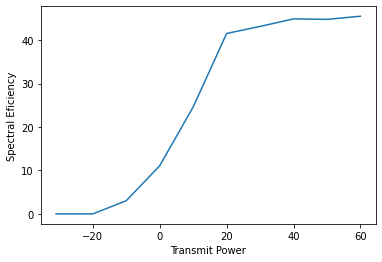

In [ ]:
#Plot the SE vs Max Transmit power (EPA)
pyplot.xlabel("Transmit Power")
pyplot.ylabel("Spectral Eficiency")
pyplot.plot(x_axis, y_axis)
pyplot.show()

In [ ]:
#Finding Optimal SE values in FPA case

#initialise maximum power to -30mW
P_max = -30
#array to store P_max and corresponding optimal SE values
Full_power_x = [-31]
Full_power_y = [0]

#iterate over different P_max values
for loop in range(10):
  curr = 0
  #Find average optimal SE for given P_max
  for j in range(10):
   curr = curr + objective(P_max)
  
  curr = (curr/10.0)
  #Add the (P_max, Optimal_SE) points
  Full_power_x.append(P_max)
  Full_power_y.append(curr)

  print('P_max = %.3f, Optimal_SE = %.3f' % (P_max, curr))
  P_max = P_max + 10


P_max = -30.000, Optimal_SE = 0.020
P_max = -20.000, Optimal_SE = 0.692
P_max = -10.000, Optimal_SE = 3.560
P_max = 0.000, Optimal_SE = 11.977
P_max = 10.000, Optimal_SE = 24.907
P_max = 20.000, Optimal_SE = 29.969
P_max = 30.000, Optimal_SE = 34.374
P_max = 40.000, Optimal_SE = 33.124
P_max = 50.000, Optimal_SE = 34.467
P_max = 60.000, Optimal_SE = 32.454


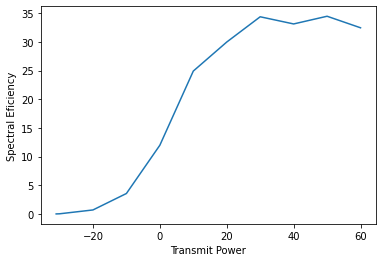

In [ ]:
##Plot the SE vs Max Transmit power (FPA)
pyplot.xlabel("Transmit Power")
pyplot.ylabel("Spectral Eficiency")
pyplot.plot(Full_power_x, Full_power_y)
pyplot.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


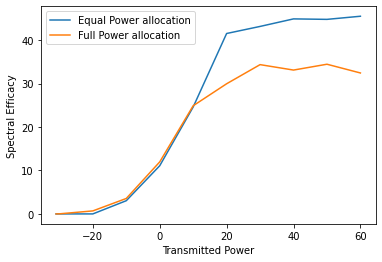

In [ ]:
#EPA vs FPA comparison plot 
pyplot.xlabel("Transmitted Power")
pyplot.ylabel("Spectral Efficacy")
pyplot.plot(x_axis, y_axis)
pyplot.plot(Full_power_x, Full_power_y)
pyplot.legend(["Equal Power allocation","Full Power allocation"])
pyplot.show()
